In [18]:
import csv
import os

import numpy as np
import pandas as pd
from epiweeks import Week
from haversine import haversine
os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

import pickle
import matplotlib.pyplot as plt
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from model import STAN

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [19]:
def gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=1):
    """
    This function calculates the edge via the gravity law
    :param lat1: latitude of location 1
    :type lat1: float
    :param lng1: longitude of location 1
    :type lat1: float
    :param pop1: population of location 1
    :type lat1: float or int
    :param lat2: latitude of location 2
    :type lat1: float
    :param lng2: longitude of location 2
    :type lat1: float
    :param pop2: population of location 2
    :type lat1: float or int
    :param r: diameter, by default 1
    :type lat1: float or int
    :return: edge value
    :rtype: float or int
    """
    d = haversine((lat1, lng1), (lat2, lng2), 'km')
    c = 1
    w = 0
    alpha = 0.1
    beta = 0.1
    r = 1e4
    
    w = (np.exp(-d / r)) / (abs((pop1 ** alpha) - (pop2 ** beta))+1e-5)
    return w

In [25]:
GenerateTrainingData().download_jhu_data('2020-05-01', '2020-12-01')

Finish download


c:\Users\olarinoyem\Documents\GitHub\STAN\data_downloader.py:43: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, 'date_today'] = pd.to_datetime(data['date_today'])


,state,latitude,longitude,fips,date_today,confirmed,deaths,recovered,active,hospitalization,new_cases
0,Alabama,32.3182,-86.9023,1,2020-05-03,7977,290,0.0,7687.0,12.0,277
0,Alabama,32.3182,-86.9023,1,2020-05-04,8203,298,0.0,7905.0,29.0,226
0,Alabama,32.3182,-86.9023,1,2020-05-05,8520,315,391.0,198.0,43.0,317
0,Alabama,32.3182,-86.9023,1,2020-05-06,8769,343,405.0,192.0,51.0,249
0,Alabama,32.3182,-86.9023,1,2020-05-07,9115,369,409.0,215.0,20.0,346
...,...,...,...,...,...,...,...,...,...,...,...
57,Wyoming,42.7560,-107.3025,56,2020-11-27,31773,215,21700.0,9858.0,0.0,1012
57,Wyoming,42.7560,-107.3025,56,2020-11-28,31928,215,22798.0,8915.0,0.0,155
57,Wyoming,42.7560,-107.3025,56,2020-11-29,32489,215,23022.0,9252.0,0.0,561
57,Wyoming,42.7560,-107.3025,56,2020-11-30,33305,215,24478.0,8612.0,0.0,816


In [50]:
data_utla = pd.read_csv("../data/UTLA_region/merged_UTLA.csv")
data_utla

,date,areaName,areaCode,dailyCases,dailyDeaths,cumulativeCases,cumulativeDeaths,day,population,long,lat
0,2023-05-25,Wokingham,E06000041,38.0,1,67480,416.0,1133,"178,169",-0.89935,51.42296
1,2023-05-18,Wokingham,E06000041,27.0,1,67442,415.0,1126,"178,169",-0.89935,51.42296
2,2023-05-11,Wokingham,E06000041,40.0,3,67415,414.0,1119,"178,169",-0.89935,51.42296
3,2023-05-04,Wokingham,E06000041,36.0,2,67375,411.0,1112,"178,169",-0.89935,51.42296
4,2023-04-27,Wokingham,E06000041,43.0,1,67339,409.0,1105,"178,169",-0.89935,51.42296
...,...,...,...,...,...,...,...,...,...,...,...
147015,2020-04-21,Worcestershire,E10000034,29.0,0,916,NaN,4,"604,947",-2.20935,52.21287
147016,2020-04-20,Worcestershire,E10000034,42.0,0,887,NaN,3,"604,947",-2.20935,52.21287
147017,2020-04-19,Worcestershire,E10000034,40.0,0,845,NaN,2,"604,947",-2.20935,52.21287
147018,2020-04-18,Worcestershire,E10000034,43.0,0,805,NaN,1,"604,947",-2.20935,52.21287


In [72]:
print(data_utla[data_utla["areaName"] == "Wokingham"])


           date   areaName   areaCode  dailyCases  dailyDeaths   
0    2023-05-25  Wokingham  E06000041        38.0            1  \
1    2023-05-18  Wokingham  E06000041        27.0            1   
2    2023-05-11  Wokingham  E06000041        40.0            3   
3    2023-05-04  Wokingham  E06000041        36.0            2   
4    2023-04-27  Wokingham  E06000041        43.0            1   
..          ...        ...        ...         ...          ...   
694  2020-04-23  Wokingham  E06000041         2.0            0   
695  2020-04-22  Wokingham  E06000041         8.0            0   
696  2020-04-21  Wokingham  E06000041        43.0            0   
697  2020-04-19  Wokingham  E06000041        21.0            0   
698  2020-04-17  Wokingham  E06000041         9.0            0   

     cumulativeCases  cumulativeDeaths   day population     long       lat  
0              67480             416.0  1133    178,169 -0.89935  51.42296  
1              67442             415.0  1126    178,1

In [51]:
print(data_utla.isnull().sum())

date                    0
areaName                0
areaCode                0
dailyCases              0
dailyDeaths             0
cumulativeCases         0
cumulativeDeaths    24988
day                     0
population           1582
long                 1582
lat                  1582
dtype: int64


In [56]:
# Filter rows with missing values in 'lat' or 'long' columns
missing_rows = data_utla[data_utla['lat'].isnull() | data_utla['long'].isnull()]

# Extract the 'areaName' for the missing rows
missing_area_names = missing_rows['areaName'].unique()

# Print the 'areaName' of the missing rows
print(missing_area_names)

['Buckinghamshire' 'Northamptonshire']


In [57]:
data_utla_clean = data_utla.dropna(subset=['lat', 'long'])

In [58]:
print(data_utla_clean.dtypes)

date                 object
areaName             object
areaCode             object
dailyCases          float64
dailyDeaths           int64
cumulativeCases       int64
cumulativeDeaths    float64
day                   int64
population           object
long                float64
lat                 float64
dtype: object


In [59]:
unique_locations = data_utla.groupby('areaName').agg({'lat':'first', 'long':'first'}).reset_index()

unique_locations


,areaName,lat,long
0,Aberdeen City,57.16697,-2.20398
1,Aberdeenshire,57.23469,-2.79208
2,Angus,56.72518,-2.89210
3,Antrim and Newtownabbey,54.69386,-6.17760
4,Ards and North Down,54.56409,-5.64568
...,...,...,...
209,Wokingham,51.42296,-0.89935
210,Wolverhampton,52.59788,-2.12746
211,Worcestershire,52.21287,-2.20935
212,Wrexham,53.00167,-2.99203


In [60]:
print(data_utla.duplicated().sum())


0


In [63]:
print(data_utla_clean.isnull().sum())

date                    0
areaName                0
areaCode                0
dailyCases              0
dailyDeaths             0
cumulativeCases         0
cumulativeDeaths    24776
day                     0
population              0
long                    0
lat                     0
dtype: int64


In [26]:
#Merge population data with downloaded data
raw_data = pickle.load(open('./data/state_covid_data.pickle','rb'))
pop_data = pd.read_csv('./uszips.csv')
pop_data = pop_data.groupby('state_name').agg({'population':'sum', 'density':'mean', 'lat':'mean', 'lng':'mean'}).reset_index()
raw_data = pd.merge(raw_data, pop_data, how='inner', left_on='state', right_on='state_name')

In [67]:
# Generate location similarity
loc_list = list(data_utla_clean['areaName'].unique())
loc_dist_map = {}


In [68]:
loc_list

['Wokingham',
 'Leicestershire',
 'Scottish Borders',
 'Isle of Anglesey',
 'Rutland',
 'Isle of Wight',
 'Wirral',
 'Lambeth',
 'Falkirk',
 'Derby',
 'Telford and Wrekin',
 'Bristol, City of',
 'Denbighshire',
 'North East Lincolnshire',
 'Trafford',
 'Sheffield',
 'Redbridge',
 'Wigan',
 'Walsall',
 'Lewisham',
 'East Sussex',
 'North Lincolnshire',
 'Islington',
 'Suffolk',
 'Causeway Coast and Glens',
 'City of Edinburgh',
 'Nottingham',
 'Portsmouth',
 'Dudley',
 'Staffordshire',
 'Blaenau Gwent',
 'York',
 'Kirklees',
 'Lancashire',
 'East Dunbartonshire',
 'Merthyr Tydfil',
 'Blackburn with Darwen',
 'Thurrock',
 'Medway',
 'Cornwall and Isles of Scilly',
 'Leicester',
 'Cheshire East',
 'Solihull',
 'Hampshire',
 'Bradford',
 'Gateshead',
 'Kensington and Chelsea',
 'Hertfordshire',
 'Merton',
 'Sutton',
 'Belfast',
 'Renfrewshire',
 'Conwy',
 'Redcar and Cleveland',
 'East Riding of Yorkshire',
 'Newcastle upon Tyne',
 'Haringey',
 'Pembrokeshire',
 'Bolton',
 'Sunderland',
 '

In [69]:
# Generate location similarity
loc_list = list(data_utla_clean['areaName'].unique())
loc_dist_map = {}

for each_loc in loc_list:
    loc_dist_map[each_loc] = {}
    for each_loc2 in loc_list:
        lat1 = data_utla_clean[data_utla_clean['areaName']==each_loc]['lat'].unique()[0]
        lng1 = data_utla_clean[data_utla_clean['areaName']==each_loc]['long'].unique()[0]
        pop1 = float(str(data_utla_clean[data_utla_clean['areaName']==each_loc]['population'].unique()[0]).replace(',', ''))  # convert to string, remove commas, and convert to float
        
        lat2 = data_utla_clean[data_utla_clean['areaName']==each_loc2]['lat'].unique()[0]
        lng2 = data_utla_clean[data_utla_clean['areaName']==each_loc2]['long'].unique()[0]
        pop2 = float(str(data_utla_clean[data_utla_clean['areaName']==each_loc2]['population'].unique()[0]).replace(',', ''))  # convert to string, remove commas, and convert to float
        
        loc_dist_map[each_loc][each_loc2] = gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5)


KeyboardInterrupt: 

In [ ]:
loc_dist_map

{'England': {'England': 99999.99999999999,
  'Scotland': 0.7784585560810637,
  'Wales': 0.654090675066077},
 'Scotland': {'England': 0.7784585560810637,
  'Scotland': 99999.99999999999,
  'Wales': 3.666310220678057},
 'Wales': {'England': 0.654090675066077,
  'Scotland': 3.666310220678057,
  'Wales': 99999.99999999999}}

In [ ]:
# Generate Graph
dist_threshold = 18

for each_loc in loc_dist_map:
    loc_dist_map[each_loc] = {k: v for k, v in sorted(loc_dist_map[each_loc].items(), key=lambda item: item[1], reverse=True)}
    
adj_map = {}
for each_loc in loc_dist_map:
    adj_map[each_loc] = []
    for i, each_loc2 in enumerate(loc_dist_map[each_loc]):
        if loc_dist_map[each_loc][each_loc2] > dist_threshold:
            if i <= 3:
                adj_map[each_loc].append(each_loc2)
            else:
                break
        else:
            if i <= 1:
                adj_map[each_loc].append(each_loc2)
            else:
                break

rows = []
cols = []
for each_loc in adj_map:
    for each_loc2 in adj_map[each_loc]:
        rows.append(loc_list.index(each_loc))
        cols.append(loc_list.index(each_loc2))

In [ ]:
loc_dist_map['Trafford']

{'England': 99999.99999999999,
 'Scotland': 0.7784585560810637,
 'Wales': 0.654090675066077}

In [27]:
# Generate location similarity
loc_list = list(raw_data['state'].unique())
loc_dist_map = {}

for each_loc in loc_list:
    loc_dist_map[each_loc] = {}
    for each_loc2 in loc_list:
        lat1 = raw_data[raw_data['state']==each_loc]['latitude'].unique()[0]
        lng1 = raw_data[raw_data['state']==each_loc]['longitude'].unique()[0]
        pop1 = raw_data[raw_data['state']==each_loc]['population'].unique()[0]
        
        lat2 = raw_data[raw_data['state']==each_loc2]['latitude'].unique()[0]
        lng2 = raw_data[raw_data['state']==each_loc2]['longitude'].unique()[0]
        pop2 = raw_data[raw_data['state']==each_loc2]['population'].unique()[0]
        
        loc_dist_map[each_loc][each_loc2] = gravity_law_commute_dist(lat1, lng1, pop1, lat2, lng2, pop2, r=0.5)

In [28]:
loc_dist_map

{'Alabama': {'Alabama': 99999.99999999999,
  'Alaska': 0.712213977364896,
  'Arizona': 4.698396259434448,
  'Arkansas': 4.258127278021843,
  'California': 0.6831863390239392,
  'Colorado': 13.82894158236376,
  'Connecticut': 6.045271677836252,
  'Delaware': 1.2507667550117934,
  'District of Columbia': 1.0729562129590724,
  'Florida': 1.2862349525276064,
  'Georgia': 2.668008093270385,
  'Hawaii': 0.9198672119925891,
  'Idaho': 1.6244016699415165,
  'Illinois': 1.9234010256631642,
  'Indiana': 6.247420986106947,
  'Iowa': 4.412319481592568,
  'Kansas': 3.821623789726329,
  'Kentucky': 22.510764001960286,
  'Louisiana': 48.38728880945531,
  'Maine': 1.439021711208862,
  'Maryland': 8.964416519381071,
  'Massachusetts': 5.216787377396814,
  'Michigan': 2.5503809397192154,
  'Minnesota': 14.205549978976938,
  'Mississippi': 4.39199642762415,
  'Missouri': 8.675656313241515,
  'Montana': 1.1613051897671864,
  'Nebraska': 2.081590297746719,
  'Nevada': 3.2627883290907578,
  'New Hampshire':

In [29]:
#Generate Graph
dist_threshold = 18

for each_loc in loc_dist_map:
    loc_dist_map[each_loc] = {k: v for k, v in sorted(loc_dist_map[each_loc].items(), key=lambda item: item[1], reverse=True)}
    
adj_map = {}
for each_loc in loc_dist_map:
    adj_map[each_loc] = []
    for i, each_loc2 in enumerate(loc_dist_map[each_loc]):
        if loc_dist_map[each_loc][each_loc2] > dist_threshold:
            if i <= 3:
                adj_map[each_loc].append(each_loc2)
            else:
                break
        else:
            if i <= 1:
                adj_map[each_loc].append(each_loc2)
            else:
                break

rows = []
cols = []
for each_loc in adj_map:
    for each_loc2 in adj_map[each_loc]:
        rows.append(loc_list.index(each_loc))
        cols.append(loc_list.index(each_loc2))

In [30]:
loc_dist_map['Alabama']

{'Alabama': 99999.99999999999,
 'South Carolina': 108.59741605206139,
 'Louisiana': 48.38728880945531,
 'Kentucky': 22.510764001960286,
 'Minnesota': 14.205549978976938,
 'Colorado': 13.82894158236376,
 'Wisconsin': 10.795427380999408,
 'Oklahoma': 9.074260314573179,
 'Maryland': 8.964416519381071,
 'Oregon': 8.844877384003981,
 'Missouri': 8.675656313241515,
 'Tennessee': 6.516674814297488,
 'Indiana': 6.247420986106947,
 'Connecticut': 6.045271677836252,
 'Massachusetts': 5.216787377396814,
 'Arizona': 4.698396259434448,
 'Puerto Rico': 4.657146487291393,
 'Iowa': 4.412319481592568,
 'Mississippi': 4.39199642762415,
 'Arkansas': 4.258127278021843,
 'Kansas': 3.821623789726329,
 'Washington': 3.7263666616973925,
 'Utah': 3.6852680669627205,
 'Virginia': 3.4453625864353064,
 'Nevada': 3.2627883290907578,
 'New Jersey': 2.99873381795453,
 'Georgia': 2.668008093270385,
 'North Carolina': 2.604392803968267,
 'Michigan': 2.5503809397192154,
 'New Mexico': 2.2078808084657666,
 'Ohio': 2.134

In [31]:
g = dgl.graph((rows, cols))

In [32]:
#Preprocess features

active_cases = []
confirmed_cases = []
new_cases = []
death_cases = []
static_feat = []

for i, each_loc in enumerate(loc_list):
    active_cases.append(raw_data[raw_data['state'] == each_loc]['active'])
    confirmed_cases.append(raw_data[raw_data['state'] == each_loc]['confirmed'])
    new_cases.append(raw_data[raw_data['state'] == each_loc]['new_cases'])
    death_cases.append(raw_data[raw_data['state'] == each_loc]['deaths'])
    static_feat.append(np.array(raw_data[raw_data['state'] == each_loc][['population','density','lng','lat']]))
    
active_cases = np.array(active_cases)
confirmed_cases = np.array(confirmed_cases)
death_cases = np.array(death_cases)
new_cases = np.array(new_cases)
static_feat = np.array(static_feat)[:, 0, :]
recovered_cases = confirmed_cases - active_cases - death_cases
susceptible_cases = np.expand_dims(static_feat[:, 0], -1) - active_cases - recovered_cases

# Batch_feat: new_cases(dI), dR, dS
#dI = np.array(new_cases)
dI = np.concatenate((np.zeros((active_cases.shape[0],1), dtype=np.float32), np.diff(active_cases)), axis=-1)
dR = np.concatenate((np.zeros((recovered_cases.shape[0],1), dtype=np.float32), np.diff(recovered_cases)), axis=-1)
dS = np.concatenate((np.zeros((susceptible_cases.shape[0],1), dtype=np.float32), np.diff(susceptible_cases)), axis=-1)

In [33]:
#Build normalizer
normalizer = {'S':{}, 'I':{}, 'R':{}, 'dS':{}, 'dI':{}, 'dR':{}}

for i, each_loc in enumerate(loc_list):
    normalizer['S'][each_loc] = (np.mean(susceptible_cases[i]), np.std(susceptible_cases[i]))
    normalizer['I'][each_loc] = (np.mean(active_cases[i]), np.std(active_cases[i]))
    normalizer['R'][each_loc] = (np.mean(recovered_cases[i]), np.std(recovered_cases[i]))
    normalizer['dI'][each_loc] = (np.mean(dI[i]), np.std(dI[i]))
    normalizer['dR'][each_loc] = (np.mean(dR[i]), np.std(dR[i]))
    normalizer['dS'][each_loc] = (np.mean(dS[i]), np.std(dS[i]))

In [34]:
def prepare_data(data, sum_I, sum_R, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    n_feat = data.shape[2]
    
    x = []
    y_I = []
    y_R = []
    last_I = []
    last_R = []
    concat_I = []
    concat_R = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        x.append(data[:, i:i+history_window, :].reshape((n_loc, history_window*n_feat)))
        
        concat_I.append(data[:, i+history_window-1, 0])
        concat_R.append(data[:, i+history_window-1, 1])
        last_I.append(sum_I[:, i+history_window-1])
        last_R.append(sum_R[:, i+history_window-1])

        y_I.append(data[:, i+history_window:i+history_window+pred_window, 0])
        y_R.append(data[:, i+history_window:i+history_window+pred_window, 1])

    x = np.array(x, dtype=np.float32).transpose((1, 0, 2))
    last_I = np.array(last_I, dtype=np.float32).transpose((1, 0))
    last_R = np.array(last_R, dtype=np.float32).transpose((1, 0))
    concat_I = np.array(concat_I, dtype=np.float32).transpose((1, 0))
    concat_R = np.array(concat_R, dtype=np.float32).transpose((1, 0))
    y_I = np.array(y_I, dtype=np.float32).transpose((1, 0, 2))
    y_R = np.array(y_R, dtype=np.float32).transpose((1, 0, 2))
    return x, last_I, last_R, concat_I, concat_R, y_I, y_R

In [35]:
valid_window = 25
test_window = 25

history_window=6
pred_window=15
slide_step=5

normalize = True

dynamic_feat = np.concatenate((np.expand_dims(dI, axis=-1), np.expand_dims(dR, axis=-1), np.expand_dims(dS, axis=-1)), axis=-1)
    
#Normalize
if normalize:
    for i, each_loc in enumerate(loc_list):
        dynamic_feat[i, :, 0] = (dynamic_feat[i, :, 0] - normalizer['dI'][each_loc][0]) / normalizer['dI'][each_loc][1]
        dynamic_feat[i, :, 1] = (dynamic_feat[i, :, 1] - normalizer['dR'][each_loc][0]) / normalizer['dR'][each_loc][1]
        dynamic_feat[i, :, 2] = (dynamic_feat[i, :, 2] - normalizer['dS'][each_loc][0]) / normalizer['dS'][each_loc][1]

dI_mean = []
dI_std = []
dR_mean = []
dR_std = []

for i, each_loc in enumerate(loc_list):
    dI_mean.append(normalizer['dI'][each_loc][0])
    dR_mean.append(normalizer['dR'][each_loc][0])
    dI_std.append(normalizer['dI'][each_loc][1])
    dR_std.append(normalizer['dR'][each_loc][1])

dI_mean = np.array(dI_mean)
dI_std = np.array(dI_std)
dR_mean = np.array(dR_mean)
dR_std = np.array(dR_std)

#Split train-test
train_feat = dynamic_feat[:, :-valid_window-test_window, :]
val_feat = dynamic_feat[:, -valid_window-test_window:-test_window, :]
test_feat = dynamic_feat[:, -test_window:, :]

train_x, train_I, train_R, train_cI, train_cR, train_yI, train_yR = prepare_data(train_feat, active_cases[:, :-valid_window-test_window], recovered_cases[:, :-valid_window-test_window], history_window, pred_window, slide_step)
val_x, val_I, val_R, val_cI, val_cR, val_yI, val_yR = prepare_data(val_feat, active_cases[:, -valid_window-test_window:-test_window], recovered_cases[:, -valid_window-test_window:-test_window], history_window, pred_window, slide_step)
test_x, test_I, test_R, test_cI, test_cR, test_yI, test_yR = prepare_data(test_feat, active_cases[:, -test_window:], recovered_cases[:, -test_window:], history_window, pred_window, slide_step)

In [36]:
#Build STAN model

in_dim = 3*history_window
hidden_dim1 = 32
hidden_dim2 = 32
gru_dim = 32
num_heads = 1
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

g = g.to(device)
model = STAN(g, in_dim, hidden_dim1, hidden_dim2, gru_dim, num_heads, pred_window, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [37]:
model

STAN(
  (layer1): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=18, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (layer2): MultiHeadGATLayer(
    (heads): ModuleList(
      (0): GATLayer(
        (fc): Linear(in_features=32, out_features=32, bias=True)
        (attn_fc): Linear(in_features=64, out_features=1, bias=True)
      )
    )
  )
  (gru): GRUCell(32, 32)
  (nn_res_I): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_R): Linear(in_features=34, out_features=15, bias=True)
  (nn_res_sir): Linear(in_features=34, out_features=2, bias=True)
)

In [38]:
train_x = torch.tensor(train_x).to(device)
train_I = torch.tensor(train_I).to(device)
train_R = torch.tensor(train_R).to(device)
train_cI = torch.tensor(train_cI).to(device)
train_cR = torch.tensor(train_cR).to(device)
train_yI = torch.tensor(train_yI).to(device)
train_yR = torch.tensor(train_yR).to(device)

val_x = torch.tensor(val_x).to(device)
val_I = torch.tensor(val_I).to(device)
val_R = torch.tensor(val_R).to(device)
val_cI = torch.tensor(val_cI).to(device)
val_cR = torch.tensor(val_cR).to(device)
val_yI = torch.tensor(val_yI).to(device)
val_yR = torch.tensor(val_yR).to(device)

test_x = torch.tensor(test_x).to(device)
test_I = torch.tensor(test_I).to(device)
test_R = torch.tensor(test_R).to(device)
test_cI = torch.tensor(test_cI).to(device)
test_cR = torch.tensor(test_cR).to(device)
test_yI = torch.tensor(test_yI).to(device)
test_yR = torch.tensor(test_yR).to(device)

dI_mean = torch.tensor(dI_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dI_std = torch.tensor(dI_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_mean = torch.tensor(dR_mean, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))
dR_std = torch.tensor(dR_std, dtype=torch.float32).to(device).reshape((dI_mean.shape[0], 1, 1))

N = torch.tensor(static_feat[:, 0], dtype=torch.float32).to(device).unsqueeze(-1)

In [39]:
#Train STAN

all_loss = []
file_name = './save/stan'
min_loss = 1e10

loc_name = 'California'
cur_loc = loc_list.index(loc_name)

epoch = 50 if normalize else 300
scale = 0.1

for epoch in tqdm(range(epoch)):
    model.train()
    optimizer.zero_grad()
    
    active_pred, recovered_pred, phy_active, phy_recover, _ = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
    if normalize:
        phy_active = (phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
        phy_recover = (phy_recover - dR_mean[cur_loc]) / dR_std[cur_loc]
    loss = criterion(active_pred.squeeze(), train_yI[cur_loc].squeeze())+criterion(recovered_pred.squeeze(), train_yR[cur_loc].squeeze())+scale*criterion(phy_active.squeeze(), train_yI[cur_loc].squeeze()) + scale*criterion(phy_recover.squeeze(), train_yR[cur_loc].squeeze())
    
    loss.backward()
    optimizer.step()
    all_loss.append(loss.item())
    
    model.eval()
    _, _, _, _, prev_h = model(train_x, train_cI[cur_loc], train_cR[cur_loc], N[cur_loc], train_I[cur_loc], train_R[cur_loc])
    val_active_pred, val_recovered_pred, val_phy_active, val_phy_recover, _ = model(val_x, val_cI[cur_loc], val_cR[cur_loc], N[cur_loc], val_I[cur_loc], val_R[cur_loc], prev_h)
    
    if normalize:
        val_phy_active = (val_phy_active - dI_mean[cur_loc]) / dI_std[cur_loc]
    val_loss = criterion(val_active_pred.squeeze(), val_yI[cur_loc].squeeze()) + scale*criterion(val_phy_active.squeeze(), val_yI[cur_loc].squeeze())
    if val_loss < min_loss:    
        state = {
            'state': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, file_name)
        min_loss = val_loss


100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


In [40]:
#Pred with STAN
file_name = './save/stan'
checkpoint = torch.load(file_name)
model.load_state_dict(checkpoint['state'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()


prev_x = torch.cat((train_x, val_x), dim=1)
prev_I = torch.cat((train_I, val_I), dim=1)
prev_R = torch.cat((train_R, val_R), dim=1)
prev_cI = torch.cat((train_cI, val_cI), dim=1)
prev_cR = torch.cat((train_cR, val_cR), dim=1)
prev_active_pred, _, prev_phyactive_pred, _, h = model(prev_x, prev_cI[cur_loc], prev_cR[cur_loc], N[cur_loc], prev_I[cur_loc], prev_R[cur_loc])


test_pred_active, test_pred_recovered, test_pred_phy_active, test_pred_phy_recover, _ = model(test_x, test_cI[cur_loc], test_cR[cur_loc], N[cur_loc], test_I[cur_loc], test_R[cur_loc], h)


In [41]:
if normalize:
    print('Estimated beta in SIR model is %.2f'%model.alpha_scaled)
    print('Estimated gamma in SIR model is %.2f'%model.beta_scaled)

Estimated beta in SIR model is 0.75
Estimated gamma in SIR model is 0.82


In [42]:
#Cumulate predicted dI
pred_I = []

for i in range(test_pred_active.size(1)):
    if normalize:
        cur_pred = (test_pred_active[0, i, :].detach().cpu().numpy() * dI_std[cur_loc].reshape(1, 1).detach().cpu().numpy()) + dI_mean[cur_loc].reshape(1, 1).detach().cpu().numpy()
    else:
        cur_pred = test_pred_active[0, i, :].detach().cpu().numpy()
    cur_pred = np.cumsum(cur_pred)
    cur_pred = cur_pred + test_I[cur_loc, i].detach().cpu().item()
    pred_I.append(cur_pred)
pred_I = np.array(pred_I)
pred_I = pred_I

In [43]:
def get_real_y(data, history_window=5, pred_window=15, slide_step=5):
    # Data shape n_loc, timestep, n_feat
    # Reshape to n_loc, t, history_window*n_feat
    n_loc = data.shape[0]
    timestep = data.shape[1]
    
    y = []
    for i in range(0, timestep, slide_step):
        if i+history_window+pred_window-1 >= timestep or i+history_window >= timestep:
            break
        y.append(data[:, i+history_window:i+history_window+pred_window])
    y = np.array(y, dtype=np.float32).transpose((1, 0, 2))
    return y

In [44]:
I_true = get_real_y(active_cases[:], history_window, pred_window, slide_step)

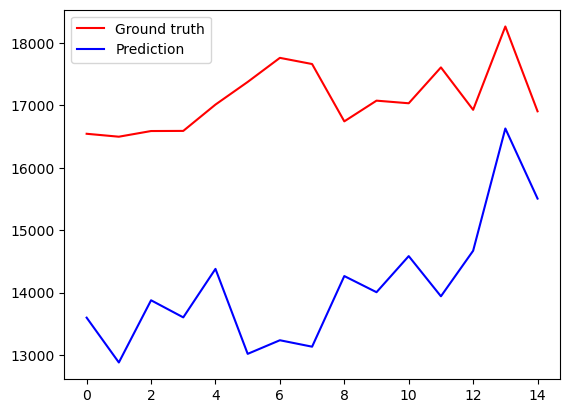

In [45]:
plt.plot(I_true[cur_loc, -1, :],c='r', label='Ground truth')
plt.plot(pred_I[-1, :],c='b', label='Prediction')
plt.legend()
plt.show()